In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import tensorflow.keras.layers as L
from tensorflow.keras.layers import Conv2D, InputSpec
from matplotlib import pyplot as plt
from PIL import Image as img
from os import listdir
from os.path import isfile, join
import cv2
import seaborn as sns

from IPython import display

In [ ]:
sns.color_palette()
p = sns.hls_palette(8, l=.5, s=.9)
sns.set_palette(p)
sns.palplot(p)

<h3>Unofficial implementation of PConv paper: https://arxiv.org/pdf/1804.07723.pdf</h3>

In [ ]:
# partial convolution layer definition
class PConv2D(tf.keras.layers.Conv2D):
    def __init__(self, *args, **kwargs):
        super(PConv2D, self).__init__(*args, **kwargs)
        self.input_spec = [InputSpec(ndim = 4), InputSpec(ndim = 4)]
        
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
            
        self.input_dim = input_shape[0][channel_axis]
        
        self.kernel_shape = self.kernel_size + (self.input_dim, self.filters)
        
        self.kernel = self.add_weight(shape = self.kernel_shape,
                                      initializer = self.kernel_initializer,
                                      name = 'image_kernel',
                                      regularizer = self.kernel_regularizer,
                                      constraint = self.kernel_constraint,
                                      trainable = True)
        
        self.window_size = self.kernel_size[0] * self.kernel_size[1]
        
        if self.use_bias:
            self.bias = self.add_weight(shape = self.filters,
                                        initializer = self.bias_initializer,
                                        name ='bias',
                                        regularizer = self.bias_regularizer,
                                        constraint = self.bias_constraint,
                                        trainable = True)
        else:
            self.bias = None
    
    def call(self, inputs):
        mask_output = K.backend.conv2d(
            inputs[1], tf.ones(self.kernel_shape),
            strides = self.strides,
            padding = self.padding,
            data_format = self.data_format,
            dilation_rate = self.dilation_rate
        )
        
        img_output = K.backend.conv2d(
            inputs[0] * inputs[1], self.kernel,
            strides = self.strides,
            padding = self.padding,
            data_format = self.data_format,
            dilation_rate = self.dilation_rate
        )
        
        mask_ratio = self.window_size / (mask_output + 1e-8)
        mask_output = K.backend.clip(mask_output, 0.0, 1.0)
        mask_ratio *= mask_output
        
        img_output = img_output * mask_ratio
        
        if self.use_bias:
            img_output = K.backend.bias_add(img_output, self.bias, data_format = self.data_format)
        
        if self.activation is not None:
            img_output = self.activation(img_output)
            
        return [img_output, mask_output]

In [ ]:
class PConvUNet():
    def __init__(self, image_size = 256, batch_size = 1, lr = 2e-4, m = 64):
        self.image_size = image_size
        self.batch_size = batch_size
        self.lr = lr
        self.ema = 0.999 # ema coeffitient to smooth out losses for visualization purposes
        self.cache_size = 1000 # how many images to load into memory == number of iterations per `epoch`
        self.optimizer = tf.optimizers.Adam(lr)
        
        # the next lines should be adjusted for your particular needs
        # in short - they should fill in two lists of files - for images and for masks
        
        #self.img_folder = "./places2_test_large/"
        self.img_folder = "C:\\places2\\data_large"
        self.msk_folder = "./masks/"
        
        #self.image_files = [f for f in listdir(self.img_folder) if isfile(join(self.img_folder, f))\
        #                    and f.endswith(".jpg")]
        
        self.image_files = []
        with open("./places2_train_standard.txt") as f:
            for line in f:
                l = line.split()
                self.image_files.append(l[0])
        
        self.mask_files  = [f for f in listdir(self.msk_folder) if isfile(join(self.msk_folder, f))\
                            and f.endswith(".png")]
        
        self.losses = {} # dictionary to store losses
        
        self.G = self.generator(m = m)
        self.G.build(input_shape = (None, image_size, image_size, 3))
        
        self.D = self.discriminator()
        self.D.build(input_shape = (None, image_size, image_size, 3))
    
    # main training loop, if needed, it will also periodically show examples of outputs.
    def train(self, epochs = 1, plot_progress = False, plot_interval = 10):
        for e in range(epochs):
            self.load_data()
            for i in range(self.cache_size):
                if i > 0:
                    print("[%d][%d/%d] Loss %f" % (e, i, self.cache_size, self.losses['total'][-1]), end = "\r")
                else:
                    print("[%d][%d/%d]" % (e, i, self.cache_size), end = "\r")
                
                x, y = self.get_batch()
                with tf.GradientTape() as gen_tape:
                    gen_output = self.G([x, y])
                    comp = x * y + (1 - y) * gen_output
                    
                    dis_real = self.D(x)
                    dis_fake = self.D(gen_output)
                    dis_comp = self.D(comp)
                    
                    gen_losses, losses_dict = self.gen_loss(dis_real, dis_fake, dis_comp, x, gen_output, y)
                    
                    for k in losses_dict.keys():
                        if k in self.losses.keys():
                            self.losses[k].append(losses_dict[k].numpy() * (1 - self.ema) +\
                                                  self.losses[k][-1] * self.ema)
                        else:
                            self.losses[k] = [losses_dict[k].numpy()]

                    gen_grads = gen_tape.gradient(gen_losses, self.G.trainable_variables)
                    self.optimizer.apply_gradients(zip(gen_grads, self.G.trainable_variables))
                
                if i % plot_interval == 0 and plot_progress:
                    self.plot_example(x[0] * y[0], x[0], gen_output[0], comp[0])
    
    # this routine loads random set of input images and masks into memory
    def load_data(self):
        self.images, self.masks = [], []

        while(len(self.images) < self.cache_size):
            r = np.random.randint(len(self.image_files))
            image = np.array(img.open(self.img_folder + self.image_files[r]).convert('RGB'), dtype = np.float32)
            h, w, _ = image.shape
            if h >= self.image_size and w >= self.image_size:
                self.images.append(image)

        while(len(self.masks) < self.cache_size):
            r = np.random.randint(len(self.mask_files))
            mask = np.array(img.open(self.msk_folder + self.mask_files[r]).convert('RGB'), dtype = np.float32)
            h, w, _ = mask.shape
            if h >= self.image_size and w >= self.image_size:
                self.masks.append(mask)
    
    # this routine gets random batch of images
    # it also draws some random circles, rectangles, lines and ellipses on each mask
    # so that in each image at least 5% is damaged
    def get_batch(self):
        masks_batch  = np.ones(shape = (self.batch_size, self.image_size, self.image_size, 3), dtype = np.float32)
        images_batch = np.ones(shape = (self.batch_size, self.image_size, self.image_size, 3), dtype = np.float32)
        
        for b in range(self.batch_size):
            while np.mean(masks_batch[b]) > 0.95:
                rm = np.random.randint(self.cache_size)
                er = np.random.randint(2, 20)
                w, h = self.image_size, self.image_size
                s = 20
                x = np.random.randint(w - self.image_size + 1)
                y = np.random.randint(h - self.image_size + 1)
                masks_batch[b] = self.masks[rm][x:x+self.image_size, y:y+self.image_size] / 255.0
                
                if np.random.random() > 0.5:
                    masks_batch[b] = cv2.erode(masks_batch[b], np.ones((er, er), np.uint8), iterations = 1)
                    masks_batch[b][masks_batch[b] > 0] = 1
                
                for _ in range(np.random.randint(20)):
                    cx = np.random.randint(w + 50) - 25
                    cy = np.random.randint(h + 50) - 25
                    radius = np.random.randint(3, s)
                    cv2.circle(masks_batch[b], (cx, cy), radius, (0, 0, 0), -1)
                    
                for _ in range(np.random.randint(20)):
                    x1, y1 = np.random.randint(1, w + 50) - 25, np.random.randint(1, h + 50) - 25
                    x2, y2 = np.random.randint(x1 - 2 * s, x1 + 2 * s), np.random.randint(y1 - 2 * s, y1 + 2 * s)
                    cv2.rectangle(masks_batch[b], (x1, y1), (x2, y2), (0, 0, 0), -1)

                for _ in range(np.random.randint(20)):
                    x1, x2 = np.random.randint(1, w + 50) - 25, np.random.randint(1, w + 50) - 25
                    y1, y2 = np.random.randint(1, h + 50) - 25, np.random.randint(1, h + 50) - 25
                    thickness = np.random.randint(1, s)
                    cv2.line(masks_batch[b], (x1, y1), (x2, y2), (0, 0, 0), thickness)

                for _ in range(np.random.randint(20)):
                    x1, y1 = np.random.randint(1, w), np.random.randint(1, h)
                    s1, s2 = np.random.randint(1, w), np.random.randint(1, h)
                    a1, a2, a3 = np.random.randint(3, 180), np.random.randint(3, 180), np.random.randint(3, 180)
                    thickness = np.random.randint(3, s)
                    cv2.ellipse(masks_batch[b], (x1, y1), (s1, s2), a1, a2, a3, (0, 0, 0), thickness)

            rl = np.random.randint(self.cache_size)
            w, h, _ = self.images[rl].shape
            x = np.random.randint(w - self.image_size + 1)
            y = np.random.randint(h - self.image_size + 1)
            images_batch[b] = self.images[rl][x:x+self.image_size, y:y+self.image_size] / 255.0
            
        return images_batch, masks_batch
    
    # generator network. m - is a multiplyer for the number of channels for convolutions
    def generator(self, m = 64):
        kernel = 3
        stride = 2

        c = [1, 2, 4, 8, 16, 16, 16, 16, 16, 16, 16, 8, 4, 2, 1]
        filters = [i * m for i in c] + [3]

        l_in = L.Input(shape=(self.image_size, self.image_size, 3), name = "gen_input_image")
        m_in = L.Input(shape=(self.image_size, self.image_size, 3), name = "gen_input_mask")

        #encoder
        ls, ms = [], []

        l, m = PConv2D(filters[0], 7, stride, activation = 'relu', padding = 'same')([l_in, m_in])
        ls.append(l)
        ms.append(m)

        for i in range(7):
            if i < 2: k = 5
            else: k = kernel
            l, m = PConv2D(filters[i + 1], k, stride, activation = 'relu', padding = 'same')([l, m])
            l = L.BatchNormalization()(l)
            ls.append(l)
            ms.append(m)

        ms = ms[::-1]
        ls = ls[::-1]

        #decoder
        for i in range(7):
            l = L.UpSampling2D(size = 2, interpolation = 'nearest')(l)
            l = L.Concatenate()([l, ls[i + 1]])
            m = L.UpSampling2D(size = 2, interpolation = 'nearest')(m)
            m = L.Concatenate()([m, ms[i + 1]])
            l, m = PConv2D(filters[i + 8], kernel, padding = 'same')([l, m])
            l = L.LeakyReLU(alpha = 0.2)(l)
            l = L.BatchNormalization()(l)

        l = L.UpSampling2D(size = 2, interpolation = 'nearest')(l)
        l = L.Concatenate()([l, l_in])
        m = L.UpSampling2D(size = 2, interpolation = 'nearest')(m)
        m = L.Concatenate()([m, m_in])
        l, m = PConv2D(filters[15], kernel, padding = 'same', activation = 'relu')([l, m])
        l = L.Conv2D(filters[15], kernel_size = 1, strides = 1, activation = 'sigmoid', name = 'output_image')(l)
    
        return K.Model(inputs = [l_in, m_in], outputs = l, name = "generator")
    
    # discriminator is a VGG16
    # you can change this function and load weights provided by TF 2.0
    def discriminator(self):
        mean = [0.485, 0.456, 0.406]
        stdev = [0.229, 0.224, 0.225]

        inputs = L.Input(shape=(self.image_size, self.image_size, 3))
        processed = L.Lambda(lambda x: (x - mean) / stdev)(inputs)

        vgg = K.applications.VGG16(weights = None, include_top = False, input_tensor = processed)
        vgg.load_weights("./vgg16.h5", by_name = True)

        vgg.outputs = [vgg.layers[i].output for i in [4, 7, 11]]
        model = K.Model(inputs = inputs, outputs = vgg.outputs)
        model.trainable = False
        model.compile(loss='mse', optimizer='adam')

        return model
    
    # this calculates all the losses described in the paper and returns total loss and a dictionary
    # with its separate components for logging
    def gen_loss(self, dis_output_real, dis_output_fake, dis_output_comp, target,\
             generated, mask, weights = [1, 6, 0.05, 120.0, 120.0, 0.1]):
    
        comp = target * mask + (1 - mask) * generated

        loss = 0
        d = {}

        # valid
        l = tf.reduce_mean(tf.abs(target * mask - generated * mask)) * weights[0]
        d['valid'] = l
        loss += l

        # hole
        l = tf.reduce_mean(tf.abs(target * (1 - mask) - generated * (1 - mask))) * weights[1]
        d['hole'] = l
        loss += l

        # perceptual losses
        for p in range(len(dis_output_real)):
            l  = tf.reduce_mean(tf.math.abs(dis_output_real[p] - dis_output_fake[p])) * weights[2]
            l += tf.reduce_mean(tf.math.abs(dis_output_comp[p] - dis_output_fake[p])) * weights[2]
            d['perceprual_' + str(p)] = l
            loss += l

        # style losses
        for p in range(len(dis_output_real)):
            b, w, h, c = dis_output_real[p].shape
            r = tf.reshape(dis_output_real[p], [b, w * h, c])
            f = tf.reshape(dis_output_fake[p], [b, w * h, c])
            k = tf.reshape(dis_output_comp[p], [b, w * h, c])

            r = tf.keras.backend.batch_dot(r, r, axes = [1, 1])
            f = tf.keras.backend.batch_dot(f, f, axes = [1, 1])
            k = tf.keras.backend.batch_dot(k, k, axes = [1, 1])

            l = tf.reduce_sum(tf.math.abs(r - f) / c**3/ h / w) * weights[3]
            d['style_fake_' + str(p)] = l
            loss += l
            l = tf.reduce_sum(tf.math.abs(r - k) / c**3/ h / w) * weights[4]
            d['style_comp_' + str(p)] = l
            loss += l

        # TV loss
        kernel = K.backend.ones(shape=(3, 3, mask.shape[3], mask.shape[3]))
        dilated_mask = K.backend.conv2d(1 - mask, kernel, data_format = 'channels_last', padding = 'same')
        dilated_mask = K.backend.cast(K.backend.greater(dilated_mask, 0), 'float32')
        TV = dilated_mask * comp

        l  = tf.reduce_mean(tf.abs(TV[:,1:,:,:] - TV[:,:-1,:,:])) * weights[5]
        l += tf.reduce_mean(tf.abs(TV[:,:,1:,:] - TV[:,:,:-1,:])) * weights[5]

        d['tv'] = l
        loss += l

        d['total'] = loss

        return loss, d
    
    def load_model(self, fname):
        self.G.load_weights(fname)
        
    def save_model(self, fname):
        self.G.save_weights(fname)
    
    # plots example outputs during training
    def plot_example(self, inp, tar, gen, comp):
        plt.close()
        fig, ax = plt.subplots(1, 4, sharex = True, figsize=(16.5, 16.5))
        
        ax[0].imshow(inp)
        ax[0].set_title('Input')
        
        ax[1].imshow(gen)
        ax[1].set_title('Generated')
        
        ax[2].imshow(tar)
        ax[2].set_title('Target')
        
        ax[3].imshow(comp)
        ax[3].set_title('Computed')
        
        display.clear_output(wait = True)
        display.display(plt.gcf())
    
    
    # also tried to use it for Super Resolution, but it seems like you need to train
    # it specifically for that purpose and you can not reuse the same parameters as in
    # general inpainting task, which is logical I guess, but was not mentioned
    # in the original paper
    def superRes(self, dilation = 2):
        assert dilation in [2, 4], "Dilation blabalbla"
        size = self.image_size // dilation
        r = np.random.randint(len(self.image_files))
        
        image = img.open(self.img_folder + self.image_files[r]).convert('RGB')
        image_x = image.resize((size, size))
        image_y = image_x.resize((self.image_size, self.image_size))
        image_x = np.array(image_x, dtype = np.float32) / 255.0
        image_y = np.array(image_y, dtype = np.float32) / 255.0
        
        inp  = np.zeros((self.image_size, self.image_size, 3), dtype = np.float32)
        inp[::dilation, ::dilation, :] = image_x
        mask = np.zeros((self.image_size, self.image_size, 3), dtype = np.float32)
        mask[::dilation, ::dilation, :] = 1.0
        
        out = self.G([image_y[None, :, :, :], mask[None, :, :, :]])
        out = out[0]
        
        fig, ax = plt.subplots(1, 4, sharex = True, figsize=(16.5, 16.5))
        
        ax[0].imshow(inp)
        ax[0].set_title('Input')
        
        ax[1].imshow(mask)
        ax[1].set_title('Mask')
        
        ax[2].imshow(image_y)
        ax[2].set_title('Target')
        
        ax[3].imshow(out)
        ax[3].set_title('Output')
        
        display.clear_output(wait = True)
        display.display(plt.gcf())
        

In [ ]:
model = PConvUNet(image_size = 256, batch_size = 6, lr = 1e-2)

In [ ]:
model.load_model("./G2_v2.h5")

In [ ]:
model.train(epochs = 50, plot_progress = True)

In [8]:
model.save_model("./G2_v2.h5")

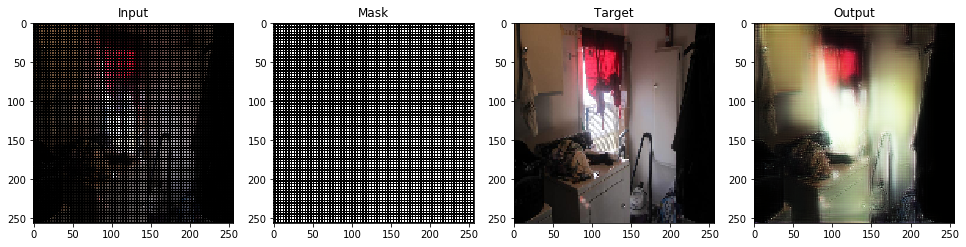

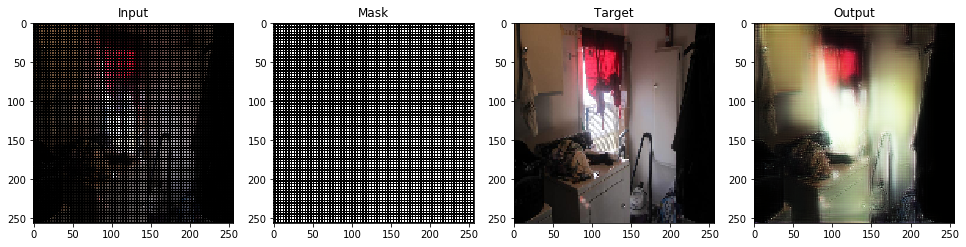

In [9]:
model.superRes(dilation = 2)